# 05 Woodland profiles and median monthly - NDVI

In this notebook we will step through an example for a single polygon and plot a the profile of a single NFI broadleaved parcel over the course of a year. Similiar to notebook 04 this example will look at the data in 2019 (160 images). We will then combine this to build a custom function that could be called over n polygons across the Park. 

We will utilse the xarray/numpy broadcasting to perform these operations. Normally these 'zonal statistics' would be performed with libraries such as rasterstats to get this information. The data cube makes the creation of this data much faster.

The potential application is enormous, profiles could be compared, or different dataset for polygons used. Again it is the ability to access all the data, rather than a select amount that offers a distinct differentiation. 

In [1]:
%matplotlib inline
import geopandas as gpd
import datacube
import numpy as np
import sys
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr
sys.path.append('./utils')
import jncc_utils # jncc utils file containing helper functions from open data cube resources
from datacube.utils import masking
import pandas as pd


# you can remove this is you want to see any warnings
import warnings
warnings.filterwarnings('ignore')

dc = datacube.Datacube()

Read the NFI data in (it is a clip to the SDNP area), perform a select Broadleaved woodland query and take the first record and plot it up. This will form the geometry / boundary to query the datacube.

<AxesSubplot:>

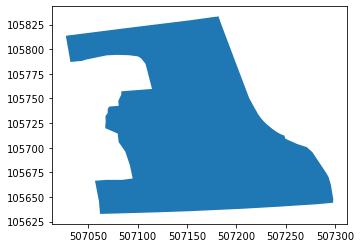

In [2]:
# read in NFI data from SDNP and plot
gdf = gpd.read_file('./data/NFI_SDNPA_2020.shp')
gdf = gdf[gdf['IFT_IOA'] == 'Broadleaved']
gdf_selected = gdf.iloc[[0]]
gdf_selected.plot()

Query the datacube. We just want the red band, band 8 (nir2) and the cloud mask. 

In [3]:
# use gdf bounds as extent for datacube query
query = {
    'time': ('2019-01-01','2019-12-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf_selected.total_bounds[0], gdf_selected.total_bounds[2]),
    'y': (gdf_selected.total_bounds[1], gdf_selected.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10),
    'measurements':('red', 'fmask', 'nir2')
}

ds = dc.load(product='sentinel2',
            dask_chunks = {},
            **query)

Mask the cloudy pixels and create the NDVI layer

In [4]:
ds['red'] = ds.red.where(ds.fmask==0)
ds['nir2'] = ds.nir2.where(ds.fmask==0)

ds = masking.mask_invalid_data(ds)
ndvi = ((ds.nir2-ds.red)/(ds.nir2+ds.red))


Select a single band (eg red) on a single time slice eg (time=0) and parse this to xr_rasterize function to mask the xarray that we can then use to mask the xarray

In [5]:
plot1 = ds.red.isel(time=0) # rasterize single slice
mask = jncc_utils.xr_rasterize(gdf_selected, plot1)

Rasterizing to match xarray.DataArray dimensions (21, 28) and projection system/CRS (e.g. EPSG:27700)


The output is can then be parsed on the ndvi layer and applied with .where

In [6]:
masked_da = ndvi.where(mask)

Fill any nan's (Not A Number) an calculate the mean at the x,y for each cell (its faster than looping over the pixels)

In [7]:
# fill nan's
masked_da = masked_da.fillna(0)
ndvi_values = masked_da.mean(['x', 'y']).values

Push the ds.time layer and the ndvi_values layer to a pandas dataframe and threshold out any values less then 0.1

In [8]:
df = pd.DataFrame({'time': list(ds.time.values), 'ndvi': list(ndvi_values)}, columns=['time', 'ndvi'])
df = df[df['ndvi'] > 0.1]
df

,time,ndvi
0,2019-01-04 11:04:39,0.182030
3,2019-01-17 11:14:09,0.362456
5,2019-01-22 11:13:51,0.350198
6,2019-01-27 11:13:29,0.315499
9,2019-02-03 11:02:49,0.306837
14,2019-02-23 11:00:39,0.167371
16,2019-02-26 11:10:49,0.290381
20,2019-03-10 10:58:51,0.350423
25,2019-03-25 10:57:09,0.217586
27,2019-03-28 11:10:49,0.361067


Plot the graph (profile)

<AxesSubplot:xlabel='time'>

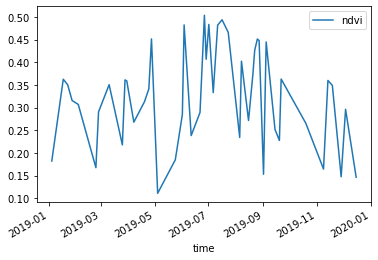

In [9]:
df.set_index('time')
df.plot(x='time', y='ndvi')

Once settled on a method this can then be grouped into a function that we can parse the geometry into to repeat for multiply geometries

In [10]:
def query_ndvi(gdf):
    query = {
    'time': ('2019-01-01','2019-12-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf.total_bounds[0], gdf.total_bounds[2]),
    'y': (gdf.total_bounds[1], gdf.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10),
    'measurements':('red', 'fmask', 'nir2')}

    ds = dc.load(product='sentinel2', dask_chunks = {}, **query)
    
    ds['red'] = ds.red.where(ds.fmask==0)
    ds['nir2'] = ds.nir2.where(ds.fmask==0)

    ds = masking.mask_invalid_data(ds)
    ndvi = ((ds.nir2-ds.red)/(ds.nir2+ds.red))
    return ndvi, ds

def get_ndvi_stats_all(ndvi_layer, ds):
        
    plot1 = ds.red.isel(time=0) # rasterize single slice
    mask = jncc_utils.xr_rasterize(gdf_selected, plot1)
    
    masked_da = ndvi_layer.where(mask)
    masked_da = masked_da.fillna(0)
    ndvi_values = masked_da.mean(['x', 'y']).values
    
    df = pd.DataFrame({'time': list(ds.time.values), 'ndvi': list(ndvi_values)}, columns=['time', 'ndvi'])
    df = df[df['ndvi'] > 0.1]
    
    df.set_index('time')
    df.plot(x='time', y='ndvi')
    return None

Try it for the first 7 records

Rasterizing to match xarray.DataArray dimensions (21, 28) and projection system/CRS (e.g. EPSG:27700)
Rasterizing to match xarray.DataArray dimensions (12, 19) and projection system/CRS (e.g. EPSG:27700)
Rasterizing to match xarray.DataArray dimensions (29, 20) and projection system/CRS (e.g. EPSG:27700)
Rasterizing to match xarray.DataArray dimensions (9, 11) and projection system/CRS (e.g. EPSG:27700)
Rasterizing to match xarray.DataArray dimensions (45, 59) and projection system/CRS (e.g. EPSG:27700)
Rasterizing to match xarray.DataArray dimensions (37, 33) and projection system/CRS (e.g. EPSG:27700)


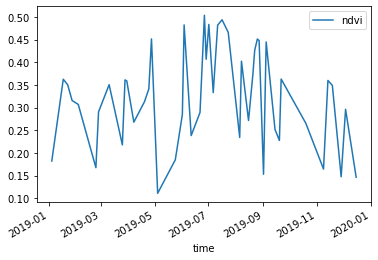

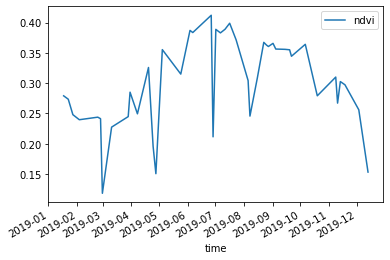

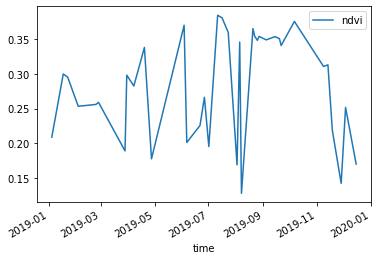

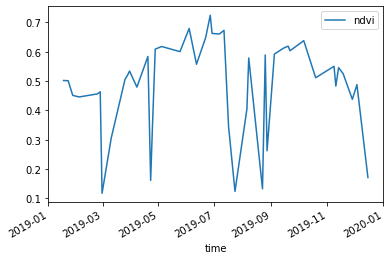

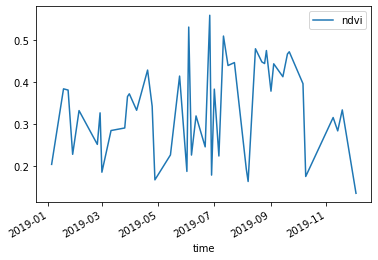

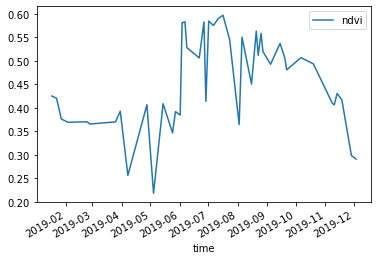

In [11]:
for i in range(0,6):
    gdf_selected = gdf.iloc[[i]]
    ndvi_layer, ds = query_ndvi(gdf_selected)
    get_ndvi_stats_all(ndvi_layer, ds)
    

Now that we have built a robust function to plot the profiles we can group these data into monthly medians and plot

In [12]:
ndvi_month_grps = ndvi.groupby('time.month')
ndvi_month_median = ndvi_month_grps.median(dim = 'time')

Unmasked plot

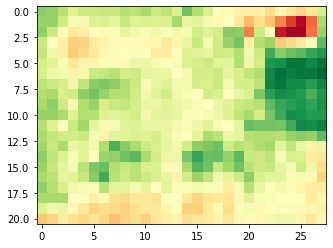

In [13]:
plt.imshow(ndvi_month_median[0], cmap="RdYlGn")

Mask and plot - notice the skew of display (pixel values remain the same)

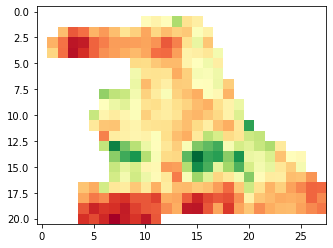

In [14]:
ndvi_month_median = ndvi_month_median.where(mask)
plt.imshow(ndvi_month_median[0], cmap="RdYlGn")

Plot a whole years worth of data - notice the seasonal greening

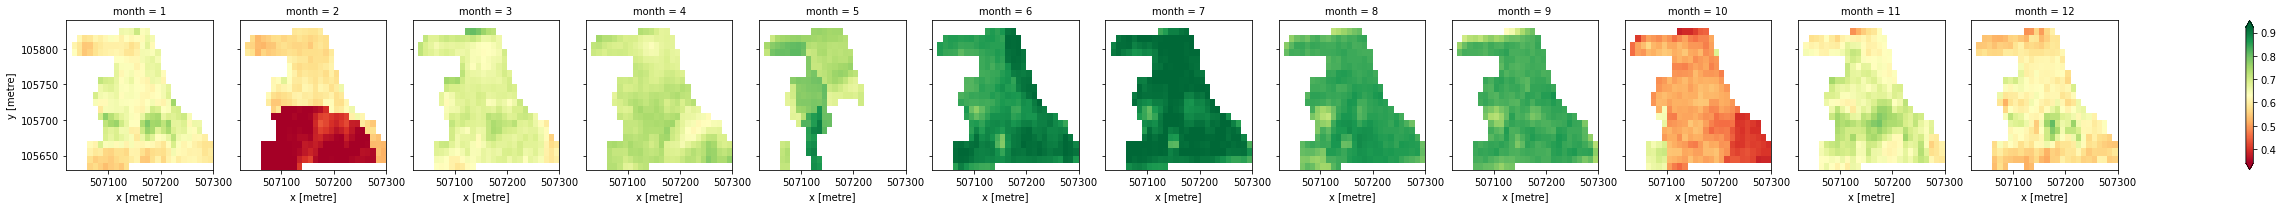

In [15]:
ndvi_month_median.plot(col="month", robust=True, cmap="RdYlGn")

Get the mean values from above

In [16]:
ndvi_values = ndvi_month_median.mean(['x', 'y']).values

Plot the single polygon monthly medians as a graph

<AxesSubplot:xlabel='time'>

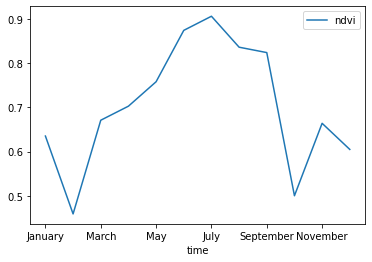

In [17]:
import calendar
m=[calendar.month_name[i] for i in range(1,13)]
df = pd.DataFrame({'time': m, 'ndvi': list(ndvi_values)}, columns=['time', 'ndvi'])
df = df[df['ndvi'] > 0.1]
df.set_index('time')
df.plot(x='time', y='ndvi')

Merge this into a function to run over multiple polygons

In [18]:
def get_ndvi_stats_monthly(ndvi_layer, ds):
        
    ndvi_month_grps = ndvi_layer.groupby('time.month')
    ndvi_month_median = ndvi_month_grps.median(dim = 'time')
    
    ndvi_values = ndvi_month_median.mean(['x', 'y']).values
    
    m=[calendar.month_name[i] for i in range(1,13)]
    df = pd.DataFrame({'time': m, 'ndvi': list(ndvi_values)}, columns=['time', 'ndvi'])
    df = df[df['ndvi'] > 0.1]
    df.set_index('time')
    df.plot(x='time', y='ndvi')
    
    return None


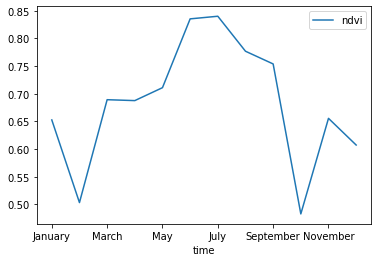

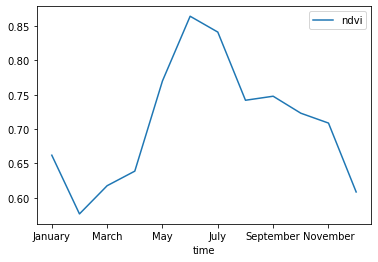

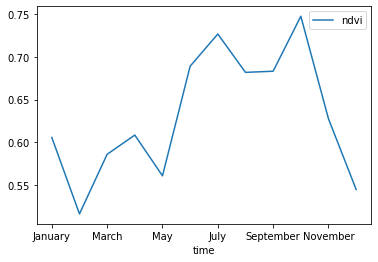

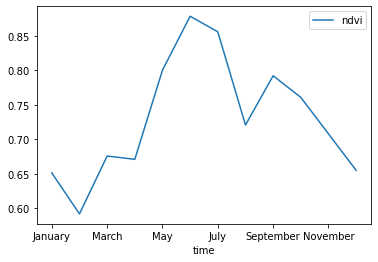

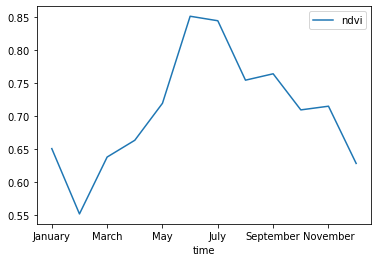

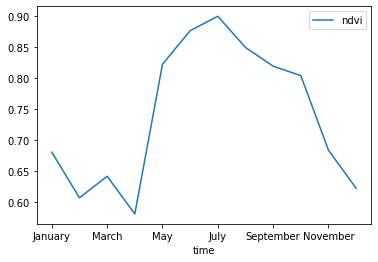

In [19]:
for i in range(0,6):
    gdf_selected = gdf.iloc[[i]]
    ndvi_layer, ds = query_ndvi(gdf_selected)
    get_ndvi_stats_monthly(ndvi_layer, ds)